#### Import bibliotek

In [44]:
import random
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs, Geometry
from rdkit.Chem import AllChem, Draw, rdFMCS, PandasTools
import os

#### Import danych z największego klastra

In [45]:
largestCluster = Chem.ForwardSDMolSupplier(os.path.join("..", "5_klastrowanie", "largest_cluster", "largest_cluster.sdf"))
mols = list(largestCluster)
legends = [mol.GetProp("molecule_name") for mol in mols]

In [46]:
largestCluster

In [47]:
legends

['CHEMBL939',
 'CHEMBL56505',
 'CHEMBL7917',
 'CHEMBL328106',
 'CHEMBL29197',
 'CHEMBL437879',
 'CHEMBL597551',
 'CHEMBL94191',
 'CHEMBL301018',
 'CHEMBL294034',
 'CHEMBL2425088',
 'CHEMBL3360602',
 'CHEMBL3355873',
 'CHEMBL3806292',
 'CHEMBL598377',
 'CHEMBL4534611',
 'CHEMBL4858176']

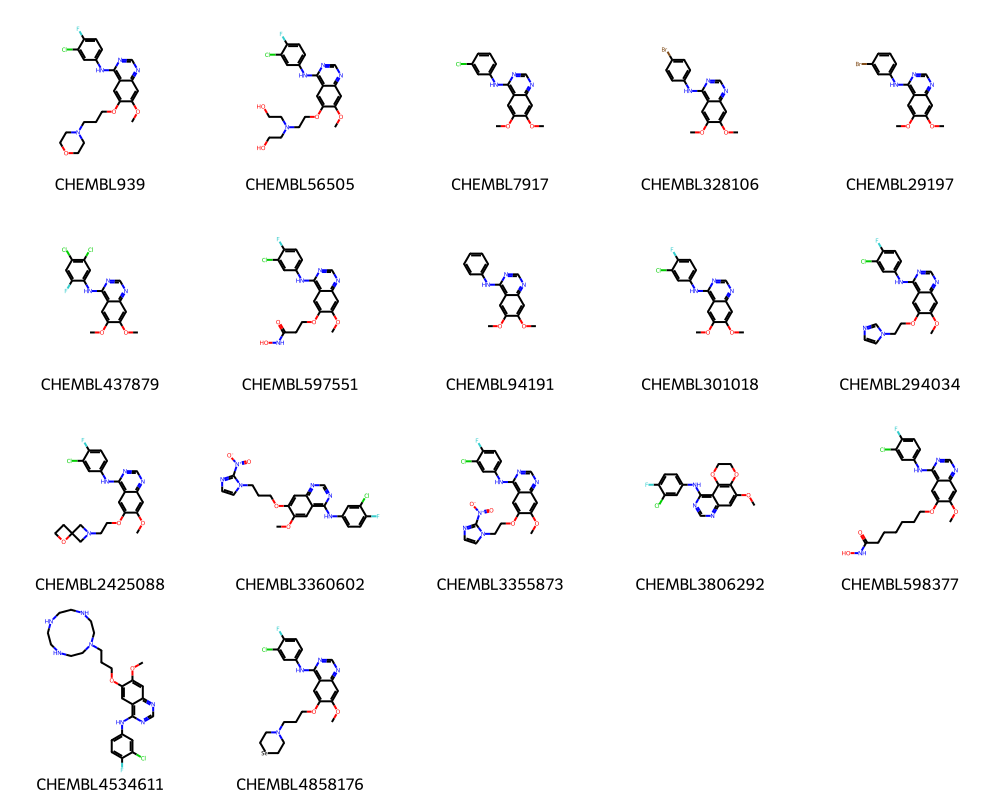

In [48]:
Draw.MolsToGridImage(mols, legends=legends, molsPerRow=5)

#### Znalezienie MCS i wyświetlenie liczby atomów i wiązań w niej występujących

In [49]:
mcs1 = rdFMCS.FindMCS(mols)
print(f"MCS1 contains {mcs1.numAtoms} atoms and {mcs1.numBonds} bonds.")
print("MCS SMARTS string:", mcs1.smartsString)
# NBVAL_CHECK_OUTPUT

MCS1 contains 21 atoms and 23 bonds.
MCS SMARTS string: [#6]-[#8]-[#6]1:[#6]:[#6]2:[#7]:[#6]:[#7]:[#6](:[#6]:2:[#6]:[#6]:1-[#8]-[#6])-[#7]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1


#### Wyświetlenie struktury MCS

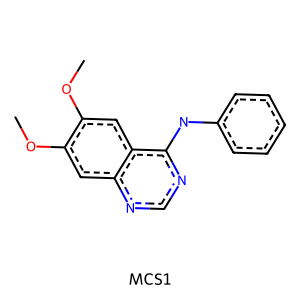

In [50]:
# Draw substructure from Smarts
m1 = Chem.MolFromSmarts(mcs1.smartsString)
Draw.MolToImage(m1, legend="MCS1")

#### Podświetlenie MCS w 5 cząsteczkach

In [51]:
def highlight_molecules(molecules, mcs, number, label=True, same_orientation=True, **kwargs):
    """Highlight the MCS in our query molecules"""
    molecules = deepcopy(molecules)
    # convert MCS to molecule
    pattern = Chem.MolFromSmarts(mcs.smartsString)
    # find the matching atoms in each molecule
    matching = [molecule.GetSubstructMatch(pattern) for molecule in molecules[:number]]

    legends = None
    if label is True:
        legends = [x.GetProp("molecule_name") for x in molecules]

    if same_orientation:
        mol, match = molecules[0], matching[0]
        AllChem.Compute2DCoords(mol)
        coords = [mol.GetConformer().GetAtomPosition(x) for x in match]
        coords2D = [Geometry.Point2D(pt.x, pt.y) for pt in coords]
        for mol, match in zip(molecules[1:number], matching[1:number]):
            if not match:
                continue
            coord_dict = {match[i]: coord for i, coord in enumerate(coords2D)}
            AllChem.Compute2DCoords(mol, coordMap=coord_dict)

    return Draw.MolsToGridImage(
        molecules[:number],
        legends=legends,
        molsPerRow=5,
        highlightAtomLists=matching[:number],
        subImgSize=(200, 200),
        **kwargs,
    )

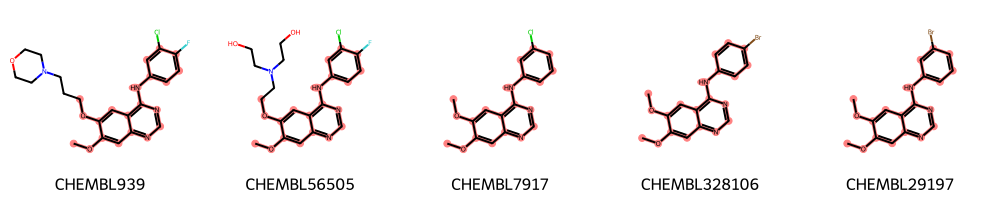

In [52]:
highlight_molecules(mols, mcs1, 5)

#### Zapisanie obrazów w formacie SVG

In [53]:
img = highlight_molecules(mols, mcs1, 5, useSVG=True)

# Get SVG data
molsvg = img.data

# Set background to transparent & Enlarge size of label
molsvg = molsvg.replace("opacity:1.0", "opacity:0.0").replace("12px", "20px")

# Save altered SVG data to file
with open("mcs_largest_cluster.svg", "w") as f:
    f.write(molsvg)

#### Znalezienie MCS w cząsteczkach, z progiem $80\%$ oraz liczby jej atomów i wiązań

In [54]:
mcs2 = rdFMCS.FindMCS(mols, threshold=0.8)
print(f"MCS2 contains {mcs2.numAtoms} atoms and {mcs2.numBonds} bonds.")
print("SMARTS string:", mcs2.smartsString)

MCS2 contains 22 atoms and 24 bonds.
SMARTS string: [#6]-[#8]-[#6]1:[#6]:[#6]2:[#7]:[#6]:[#7]:[#6](:[#6]:2:[#6]:[#6]:1-[#8]-[#6])-[#7]-[#6]1:[#6]:[#6]:[#6]:[#6](:[#6]:1)-[#17]


#### Wyświetlenie jej struktury

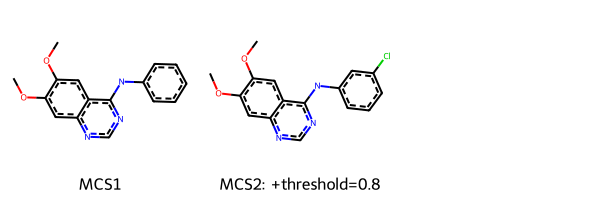

In [55]:
m2 = Chem.MolFromSmarts(mcs2.smartsString)
Draw.MolsToGridImage([m1, m2], legends=["MCS1", "MCS2: +threshold=0.8"])

#### Wyświetlenie dopasowanych atomów dla 5 cząsteczek

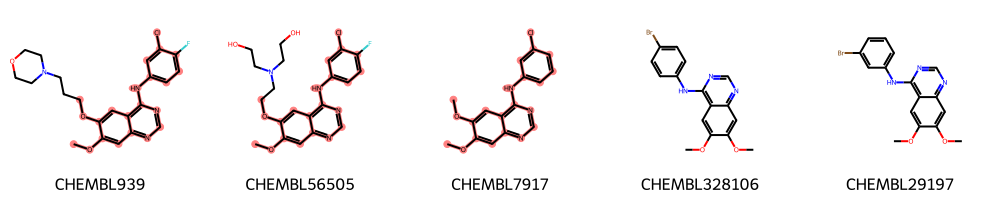

In [56]:
highlight_molecules(mols, mcs2, 5)

#### Znalezienie MCS w cząsteczkach, których pierścienie pokrywają się z pierścieniami innych cząsteczek (nie biorąc pod uwagę podfragmentów liniowych) i wypisanie jej liczby atomów i wiązań

In [57]:
mcs3 = rdFMCS.FindMCS(mols, threshold=0.8, ringMatchesRingOnly=True)
print(f"MCS3 contains {mcs3.numAtoms} atoms and {mcs3.numBonds} bonds.")
print("SMARTS string:", mcs3.smartsString)

MCS3 contains 21 atoms and 23 bonds.
SMARTS string: [#6&!R]-&!@[#8&!R]-&!@[#6]1:&@[#6]:&@[#6]2:&@[#7]:&@[#6]:&@[#7]:&@[#6](:&@[#6]:&@2:&@[#6]:&@[#6]:&@1-&!@[#8&!R]-&!@[#6&!R])-&!@[#7&!R]-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1


#### Podświetlenie dopasowanych atomów dla 5 cząsteczek

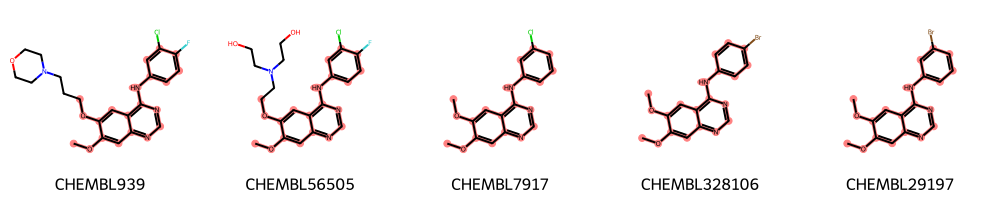

In [58]:
highlight_molecules(mols, mcs3, 5)

#### Wyświetlenie struktur wszystkich 3 MCS

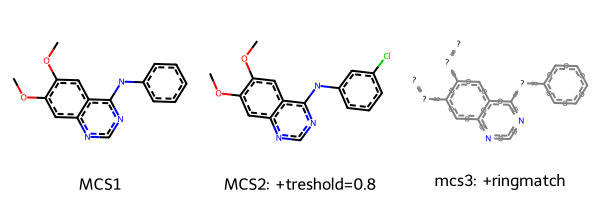

In [59]:
m3 = Chem.MolFromSmarts(mcs3.smartsString)
Draw.MolsToGridImage([m1, m2, m3], legends=["MCS1", "MCS2: +treshold=0.8", "mcs3: +ringmatch"])

#### Wczytanie danych EGFR z ćwiczenia 1 i zachowanie tylko cząsteczek z $pIC50>9$

In [60]:
egfr = pd.read_csv(os.path.join("..", "1_baza_chembl", "EGFR_combined.csv"))

In [65]:
egfr_pIC50_9_sample50 = egfr[egfr['pIC50'] > 9].shape